# №2. Загрузка данных

In [17]:
import os
from os import path
import sys
import json
import struct
from array import array
from tqdm import tqdm

from typing import Optional, Callable

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

# 0. Загрузка данных

In [51]:
DATA_FOLDER = path.join(path.curdir, 'data')
if not path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)
DATA_FOLDER

'.\\data'

### 0.1. MNIST

In [5]:
%%skip
torchvision.datasets.MNIST(root=DATA_FOLDER, train=True, download=True)

In [6]:
%%skip
torchvision.datasets.MNIST(root=DATA_FOLDER, train=False, download=True)

In [7]:
def read(dataset:str):
    path_img, path_lbl = None, None
    if dataset == 'train':
        path_img = path.join(DATA_FOLDER, 'MNIST', 'raw', 'train-images-idx3-ubyte')
        path_lbl = path.join(DATA_FOLDER, 'MNIST', 'raw', 'train-labels-idx1-ubyte')
    elif dataset == 'test':
        path_img = path.join(DATA_FOLDER, 'MNIST', 'raw', 't10k-images-idx3-ubyte')
        path_lbl = path.join(DATA_FOLDER, 'MNIST', 'raw', 't10k-labels-idx1-ubyte')
    else:
        raise ValueError(f"Invalid dataset: {dataset}")
    
    magic, size, rows, cols = None, None, None, None
    with open(path_lbl, 'rb') as f_lbl:
        magic, size = struct.unpack('>II', f_lbl.read(8))
        lbl = array('b', f_lbl.read())
    
    with open(path_img, 'rb') as f_img:
        magic, size, rows, cols = struct.unpack('>IIII', f_img.read(16))
        img = array('B', f_img.read())
        
    return lbl, img, size, rows, cols

In [8]:
def write_dataset(labels, data, size, rows, cols, output_dir:str):
    classes = {i:f"class_{i}" for i in range(10)}
    output_dirs = [
        path.join(output_dir, classes[i])
        for i in range(10)
    ]
    for dir in output_dirs:
        if not path.exists(dir):
            os.makedirs(dir)    

    for i, label in tqdm(list(enumerate(labels)), desc=f"Saving images"):
        output_filename = path.join(output_dirs[label], f"{i}.png")
        
        with open(output_filename, 'wb') as h:
            data_i = [
                data[(i*rows*cols + j*cols):(i*rows*cols + (j+1)*cols)]
                for j in range(rows)
            ]
            data_i = np.asarray(data_i)
            img = Image.fromarray(data_i)
            img.save(output_filename)    

In [9]:
OUTPUT_DIR = path.join(DATA_FOLDER, 'MNIST', 'generated')
if not path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
OUTPUT_DIR

'.\\data\\MNIST\\generated'

In [10]:
%%skip
write_dataset(*read('train'), os.path.join(OUTPUT_DIR, 'train'))

In [11]:
%%skip
write_dataset(*read('test'), os.path.join(OUTPUT_DIR, 'test'))

### 0.2 Генерация 100 тыс. изображений

In [12]:
%%skip
GEN_IMAGES_FOLDER = os.path.join(DATA_FOLDER, 'GEN_IMAGES')

if not os.path.exists(GEN_IMAGES_FOLDER):
    os.makedirs(GEN_IMAGES_FOLDER)

img = np.random.randint(0, 50, (100_000, 64, 64), dtype=np.uint8)
square = np.random.randint(100, 200, (100_000, 15, 15), dtype=np.uint8)

coords = np.empty([100_000, 2], dtype=np.int32)

data = {}

for i in tqdm(range(img.shape[0]), desc="Saving images"):
    x = np.random.randint(20, 44)
    y = np.random.randint(20, 44)
    
    img[i, (y-7):(y+8), (x-7):(x+8)] = square[i]
    coords[i] = [y, x]
    
    name_img = f"image_{i}.png"
    path_img = os.path.join(GEN_IMAGES_FOLDER, name_img)
    
    image = Image.fromarray(img[i])
    image.save(path_img)
    
    data[name_img] = [y, x]
    
with open(os.path.join(GEN_IMAGES_FOLDER, 'coords.json'), 'w') as f:
    json.dump(data, f)

# 1. MNIST для задачи классификации

## 1.2 Пользовательский класс для MNIST

In [15]:
for path, dir_path, files in os.walk(os.path.join(DATA_FOLDER, 'MNIST', 'generated', 'test', 'class_0')):
    print(f"Путь: {path}")
    print(f"\t Подпапки: {len(dir_path)} шт.")
    print(f"\t Файлы: {len(files)} шт.")
    print()

Путь: .\data\MNIST\generated\test\class_0
	 Подпапки: 0 шт.
	 Файлы: 980 шт.



In [23]:
class MNISTDataset(Dataset):
    def __init__(self, path:str, transform:Optional[Callable]=None):
        self.path = path
        self.transform = transform
        
        self.len_dataset = 0
        self.data_list = []
        
        os_walk = os.walk(self.path)
        path, dir_list, files = next(os_walk)
        self.classes = dir_list
        self.classes_to_index = {cls:i for i, cls in enumerate(sorted(self.classes))}
        
        for path, dir_list, files in os_walk:
            
            class_name = path.split(os.sep)[-1]
            
            for file in files:
                file_path = os.path.join(path, file)
                self.data_list.append((file_path, self.classes_to_index[class_name]))
            self.len_dataset += len(files)
            
    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, index:int):
        file_path, class_index = self.data_list[index]
        image = np.array(Image.open(file_path))
        if self.transform is not None:
            image = self.transform(image)
        return image, class_index

In [24]:
train_mnist = MNISTDataset(os.path.join(DATA_FOLDER, 'MNIST', 'generated', 'train'))
test_mnist = MNISTDataset(os.path.join(DATA_FOLDER, 'MNIST', 'generated', 'test'))

In [26]:
train_mnist.classes_to_index, test_mnist.classes_to_index

({'class_0': 0,
  'class_1': 1,
  'class_2': 2,
  'class_3': 3,
  'class_4': 4,
  'class_5': 5,
  'class_6': 6,
  'class_7': 7,
  'class_8': 8,
  'class_9': 9},
 {'class_0': 0,
  'class_1': 1,
  'class_2': 2,
  'class_3': 3,
  'class_4': 4,
  'class_5': 5,
  'class_6': 6,
  'class_7': 7,
  'class_8': 8,
  'class_9': 9})

In [27]:
len(train_mnist), len(test_mnist)

(60000, 10000)

(28, 28) 0 class_0


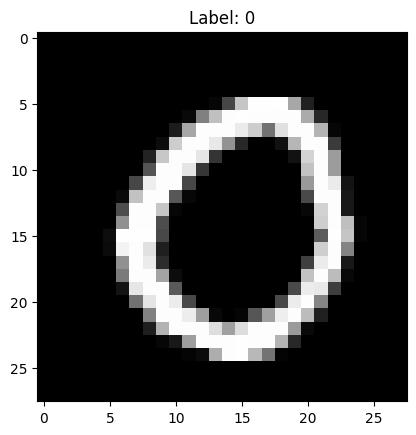

In [50]:
idx = 52
img, label = train_mnist[idx]
print(img.shape, label, train_mnist.classes[label])
plt.title(f"Label: {label}")
plt.imshow(img, cmap='gray')

In [42]:
train_data, val_data = random_split(train_mnist, [0.8, 0.2])
print(f"Train dataset length:      {len(train_data)}")
print(f"Validation dataset length: {len(val_data)}")
print(f"Test dataset length:       {len(test_mnist)}")

Train dataset length:      48000
Validation dataset length: 12000
Test dataset length:       10000


In [54]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_mnist, batch_size=batch_size, shuffle=False)

In [56]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx+1} of {len(train_loader)}")
    print(f"\tData shape: {data.shape}")
    print(f"\tTarget shape: {target.shape}")
    break

Batch 1 of 3000
	Data shape: torch.Size([16, 28, 28])
	Target shape: torch.Size([16])


## 1.2 Встроенные класс `ImageFolder`

Для `ImageFolder` важна структура файлов:
- Разные классы изображений в разных папках
- Название папки есть имя класса
- В папках хранятся изображения в форматах .jpeg, .png и т.д.

In [57]:
train_data = ImageFolder(os.path.join(DATA_FOLDER, 'MNIST', 'generated', 'train'))
test_data = ImageFolder(os.path.join(DATA_FOLDER, 'MNIST', 'generated', 'test'))

In [58]:
train_data.classes, test_data.classes

(['class_0',
  'class_1',
  'class_2',
  'class_3',
  'class_4',
  'class_5',
  'class_6',
  'class_7',
  'class_8',
  'class_9'],
 ['class_0',
  'class_1',
  'class_2',
  'class_3',
  'class_4',
  'class_5',
  'class_6',
  'class_7',
  'class_8',
  'class_9'])

In [59]:
len(train_data), len(test_data)

(60000, 10000)

<PIL.Image.Image image mode=RGB size=28x28 at 0x21288A5C170> 0 class_0
Train dataset length:      48000
Validation dataset length: 12000


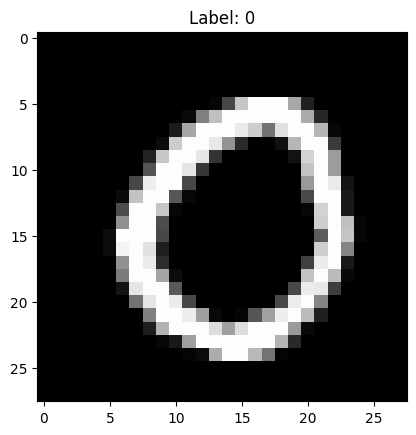

In [61]:
idx = 52
img, label = train_data[idx]
print(img, label, train_data.classes[label])
plt.title(f"Label: {label}")
plt.imshow(img, cmap='gray')
train_data, val_data = random_split(train_data, [0.8, 0.2])
print(f"Train dataset length:      {len(train_data)}")
print(f"Validation dataset length: {len(val_data)}")

In [65]:
%%skip
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx+1} of {len(train_loader)}")
    # print(f"\tData shape: {data.shape}")
    # print(f"\tTarget shape: {target.shape}")
    break

# 2. Generated images

In [68]:
os.listdir(os.path.join(DATA_FOLDER, 'GEN_IMAGES'))[:10]

(['coords.json',
  'image_0.png',
  'image_1.png',
  'image_10.png',
  'image_100.png',
  'image_1000.png',
  'image_10000.png',
  'image_10001.png',
  'image_10002.png',
  'image_10003.png'],
 100001)

In [69]:
len(os.listdir(os.path.join(DATA_FOLDER, 'GEN_IMAGES')))

100001

In [70]:
class GenImagesDataset(Dataset):
    def __init__(self, path:str, transform:Optional[Callable]=None):
        self.path = path
        self.transform = transform
        
        self.list_file_names = os.listdir(self.path)
        if 'coords.json' in self.list_file_names:
            self.list_file_names.remove('coords.json')
            
        self.len_dataset = len(self.list_file_names)
        
        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.coords = json.load(f)
        
    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, index:int):
        file_name = self.list_file_names[index]
        path_img = os.path.join(self.path, file_name)
        
        img = np.array(Image.open(path_img))
        coords = np.array(self.coords[file_name])
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, coords

In [71]:
gen_data = GenImagesDataset(os.path.join(DATA_FOLDER, 'GEN_IMAGES'))

In [72]:
len(gen_data)

100000

(64, 64) [24 33]


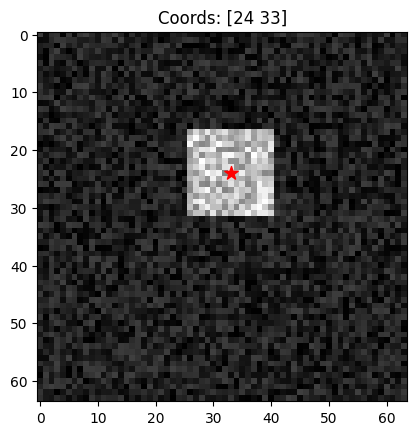

In [77]:
idx = 52
img, coords = gen_data[idx]
print(img.shape, coords)
plt.title(f"Coords: {coords}")
plt.imshow(img, cmap='gray')
plt.scatter(coords[1], coords[0], marker='*',c='red', s=100)

In [80]:
train_data, test_data = random_split(gen_data, [0.8,  0.2])
print(f"Train dataset length:      {len(train_data)}")
print(f"Test dataset length:       {len(test_data)}")
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(gen_data, batch_size=batch_size, shuffle=False)

Train dataset length:      80000
Test dataset length:       20000


In [81]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx+1} of {len(train_loader)}")
    print(f"\tData shape: {data.shape}")
    print(f"\tTarget shape: {target.shape}")
    break

Batch 1 of 1250
	Data shape: torch.Size([64, 64, 64])
	Target shape: torch.Size([64, 2])
